In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras import layers
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential, load_model
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [2]:
if tf.test.is_built_with_cuda():
    print("=======You can built with CUDA=======")
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices()[1].physical_device_desc)
    print("=====================================")
else: 
    print("CUDA not available")

=======You can built with CUDA=======
Num GPUs Available:  1
device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '../../data/landscape_Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '6000.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        color_img.append(img_to_array(img))


gray_img = []
path = '../../data/landscape_Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '6000.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

 84%|███████████████████████████████████████████████████████████████▉            | 6000/7129 [00:05<00:00, 1164.82it/s]


In [10]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(8,8))
    plt.subplot(1,3,1)
    plt.title('Цветное изображение', fontsize = 11)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('В серых тонах', fontsize = 11)
    plt.imshow(grayscale)
   
    plt.show()

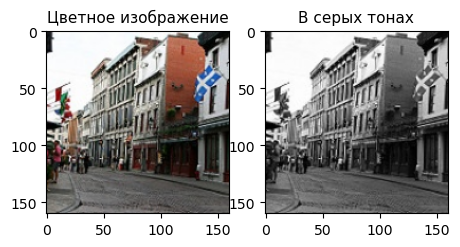

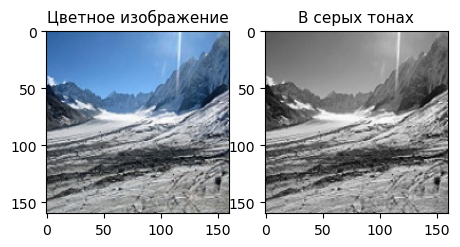

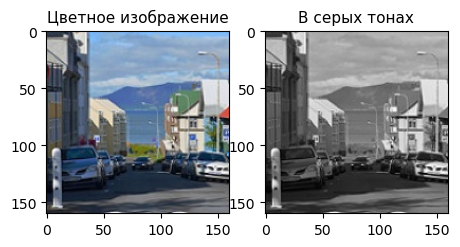

In [11]:
for i in range(3,6):
     plot_images(color_img[i],gray_img[i])

In [5]:
train_gray_image = gray_img[:5500]
train_color_image = color_img[:5500]

test_gray_image = gray_img[5500:]
test_color_image = color_img[5500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5500, 160, 160, 3)
Test color image shape (500, 160, 160, 3)


In [7]:
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [8]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [9]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 80, 80, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 40, 40, 128)  147584      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 20, 20, 256)  296192      ['sequential_1[0][0]']       

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [11]:
model.fit(train_g, train_c, epochs = 50,batch_size = 10,verbose = 1)

Epoch 1/50
550/550 [==============================] - 29s 44ms/step - loss: 0.0705 - acc: 0.4270
Epoch 2/50
550/550 [==============================] - 25s 45ms/step - loss: 0.0511 - acc: 0.4844
Epoch 3/50
550/550 [==============================] - 25s 45ms/step - loss: 0.0492 - acc: 0.4906
Epoch 4/50
550/550 [==============================] - 25s 45ms/step - loss: 0.0484 - acc: 0.4949
Epoch 5/50
550/550 [==============================] - 24s 44ms/step - loss: 0.0474 - acc: 0.5023
Epoch 6/50
550/550 [==============================] - 25s 45ms/step - loss: 0.0473 - acc: 0.5060
Epoch 7/50
550/550 [==============================] - 24s 44ms/step - loss: 0.0466 - acc: 0.5185
Epoch 8/50
550/550 [==============================] - 24s 44ms/step - loss: 0.0462 - acc: 0.5298
Epoch 9/50
550/550 [==============================] - 24s 43ms/step - loss: 0.0459 - acc: 0.5361
Epoch 10/50
550/550 [==============================] - 24s 43ms/step - loss: 0.0452 - acc: 0.5474
Epoch 11/50
550/550 [========

In [13]:
model.save("final_model.h5")

In [6]:
model = load_model(r'final_model.h5')

In [9]:
model.evaluate(test_gray_image,test_color_image, batch_size=20,)

25/25 [==============================] - 1s 34ms/step - loss: 0.0494 - acc: 0.5411


[0.04942650720477104, 0.5410537719726562]

1/1 [==============================] - 0s 404ms/step


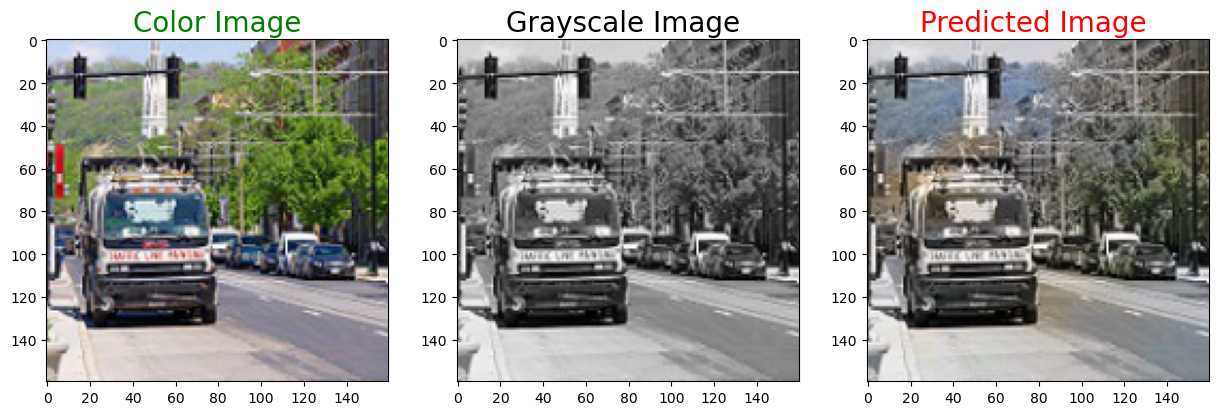

1/1 [==============================] - 0s 17ms/step


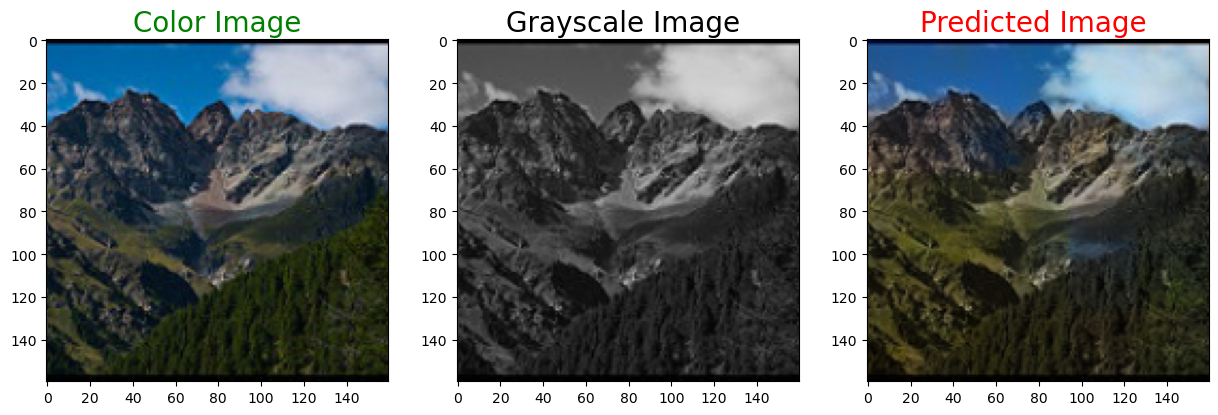

1/1 [==============================] - 0s 17ms/step


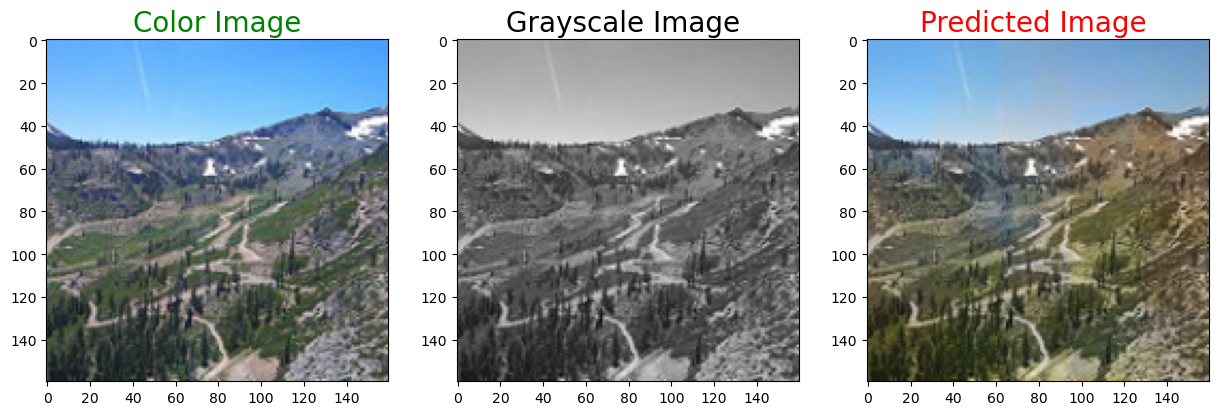

1/1 [==============================] - 0s 15ms/step


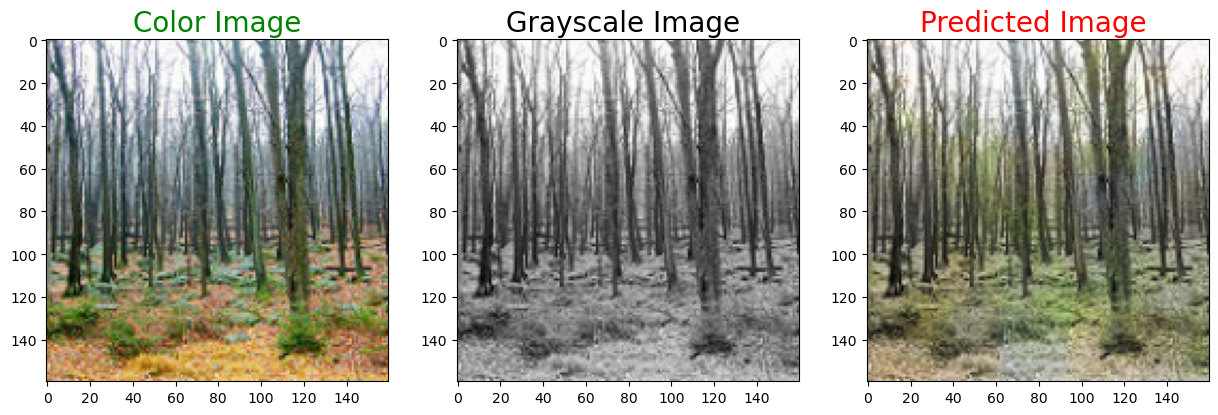

1/1 [==============================] - 0s 14ms/step


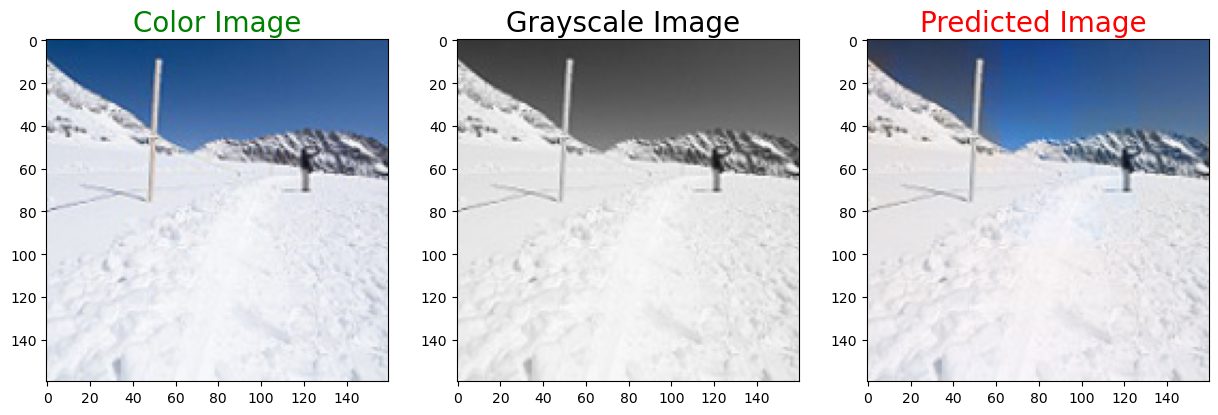

1/1 [==============================] - 0s 14ms/step


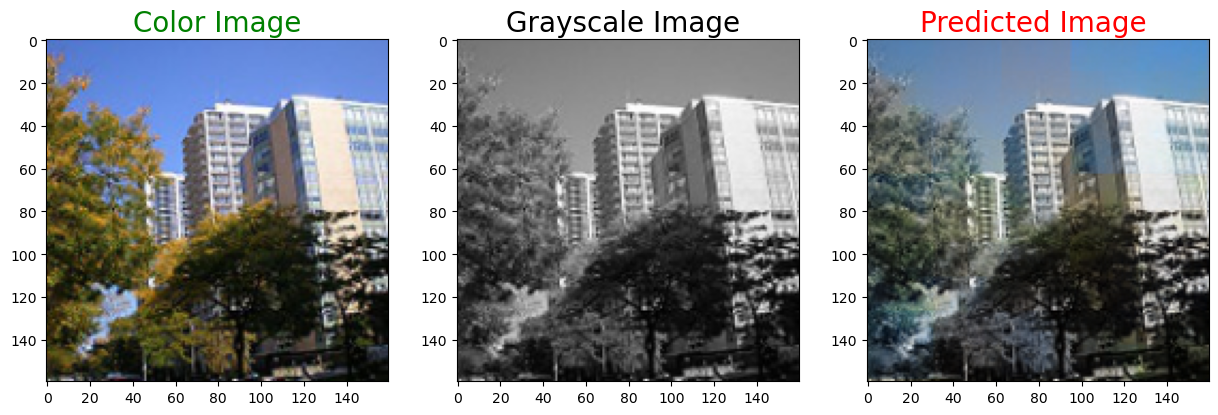

1/1 [==============================] - 0s 21ms/step


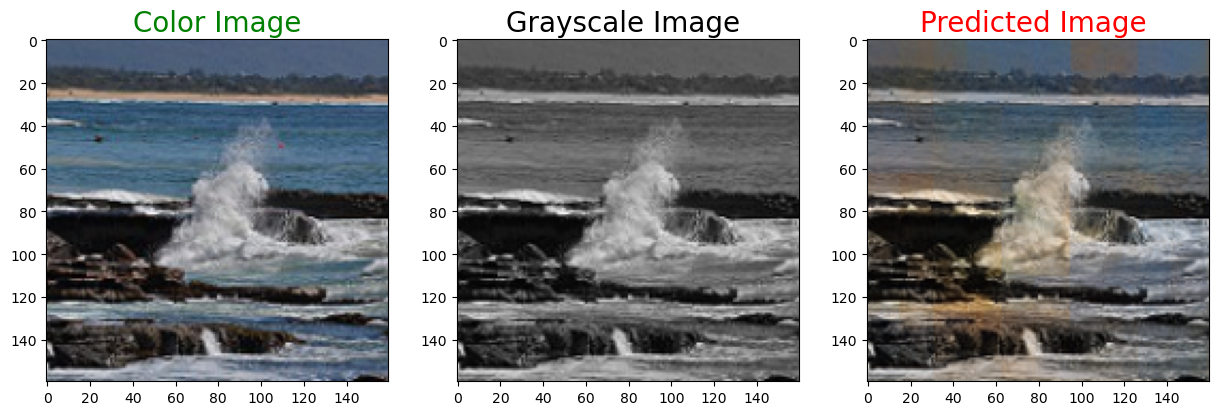

1/1 [==============================] - 0s 14ms/step


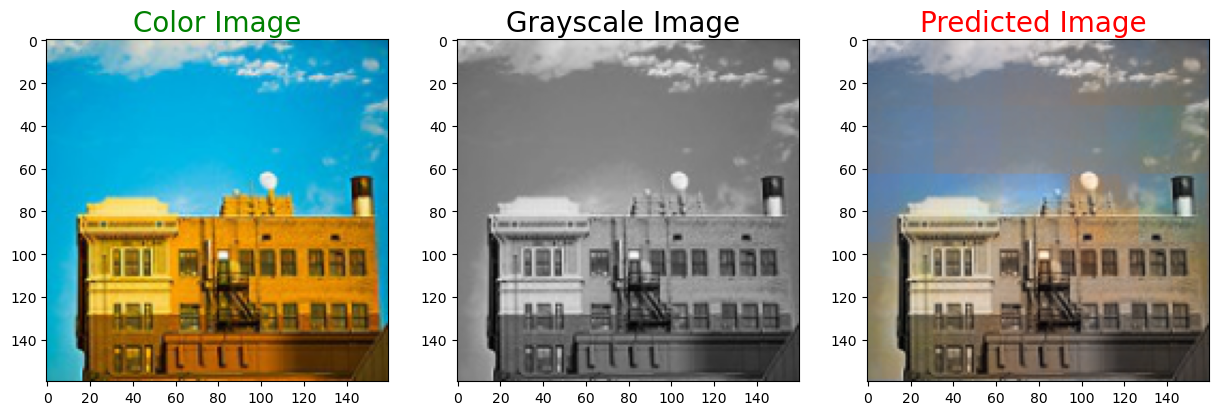

1/1 [==============================] - 0s 16ms/step


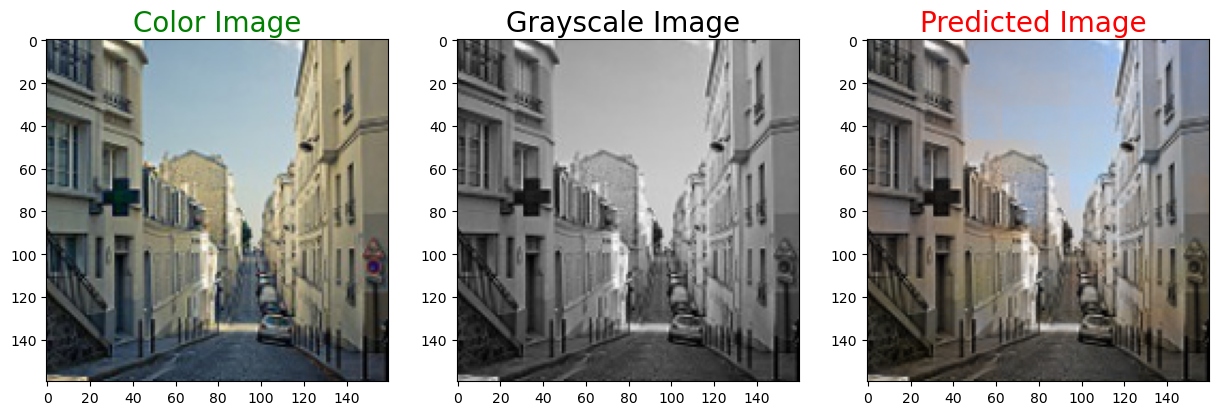

1/1 [==============================] - 0s 14ms/step


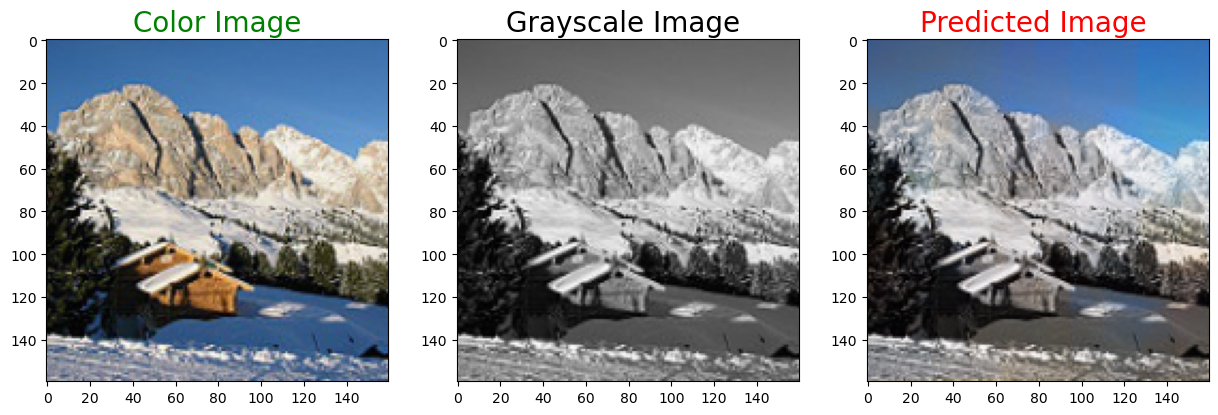

In [10]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(10,20):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

In [22]:
model = load_model(r'final_model.h5')

In [39]:
def single_predict(path, save=False):
    def plot_for_single(low,predicted):
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.title('Grey ', color = 'black', fontsize = 20)
        plt.imshow(low)
        plt.subplot(1,2,2)
        plt.title('Predicted', color = 'green', fontsize = 20)
        plt.imshow(predicted)

        plt.show()

    SIZE = 160
    img = cv2.imread(path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0

    predicted = np.clip(model.predict(img.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)

    plot_for_single(img, predicted)
    
    if save:
        file_name = 'predicted.jpg'
        cv2.imwrite(file_name, cv2.cvtColor(predicted*255, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 25ms/step


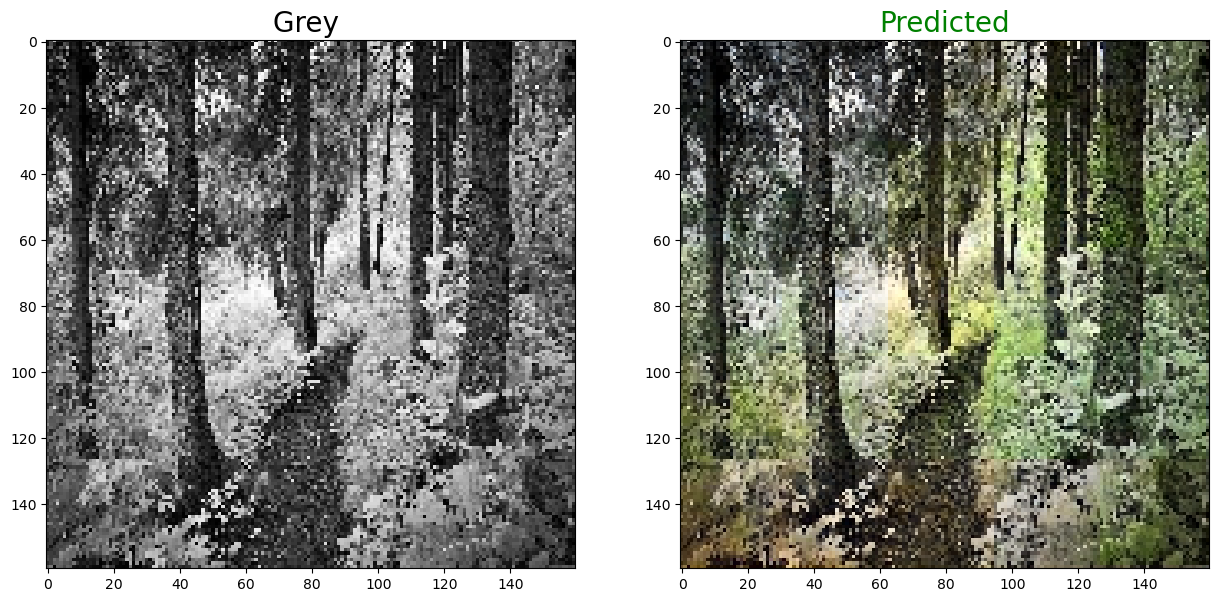

In [40]:
single_predict('6.jpg', 1)